In [2]:

import pandas as pd
import numpy as np

# ML tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [4]:
# 1. Load Dataset
# Download Telco Customer Churn dataset from Kaggle:
# https://www.kaggle.com/blastchar/telco-customer-churn
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")


In [5]:
# 2. Data Preprocessing
# -----------------------------
# Drop customerID (not useful)
df = df.drop("customerID", axis=1)

In [6]:
# Convert TotalCharges to numeric (some values are blank)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

C:\Users\Ahsan Computer\AppData\Local\Temp\ipykernel_684\1686201713.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [7]:
# Define features & target
X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})   # encode target

In [8]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [10]:
# 3. Column Transformer (scaling + encoding)
# -----------------------------
num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [11]:
# 4. Build Pipelines for Models
# -----------------------------
log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

rf_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [12]:
# 5. Hyperparameter Tuning with GridSearchCV
# -----------------------------
param_grid_lr = {
    "classifier__C": [0.01, 0.1, 1, 10],
    "classifier__solver": ["liblinear", "lbfgs"]
}

param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

# Logistic Regression GridSearch
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring="accuracy", n_jobs=-1)
grid_lr.fit(X_train, y_train)

# Random Forest GridSearch
grid_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring="accuracy", n_jobs=-1)
grid_rf.fit(X_train, y_train)


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__min_samples_split': [2, 5], 'classifier__n_estimators': [100, 200]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [13]:
# -----------------------------
# 6. Evaluate Models
# -----------------------------
print("Best Logistic Regression Params:", grid_lr.best_params_)
print("Best Logistic Regression Accuracy:", grid_lr.best_score_)

print("Best Random Forest Params:", grid_rf.best_params_)
print("Best Random Forest Accuracy:", grid_rf.best_score_)


Best Logistic Regression Params: {'classifier__C': 10, 'classifier__solver': 'lbfgs'}
Best Logistic Regression Accuracy: 0.8049317495165493
Best Random Forest Params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best Random Forest Accuracy: 0.7997845551070841


In [14]:

# Choose best model
best_model = grid_rf if grid_rf.best_score_ > grid_lr.best_score_ else grid_lr

In [15]:
# Final evaluation
y_pred = best_model.predict(X_test)
print("\nFinal Model Report:")
print(classification_report(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))



Final Model Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Test Accuracy: 0.8055358410220014


In [16]:
# 7. Save the Pipeline
# -----------------------------
joblib.dump(best_model.best_estimator_, "customer_churn_pipeline.pkl")
print("\n✅ Pipeline saved as 'customer_churn_pipeline.pkl'")


✅ Pipeline saved as 'customer_churn_pipeline.pkl'


C:\Users\Ahsan Computer\AppData\Local\Temp\ipykernel_684\1869909172.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


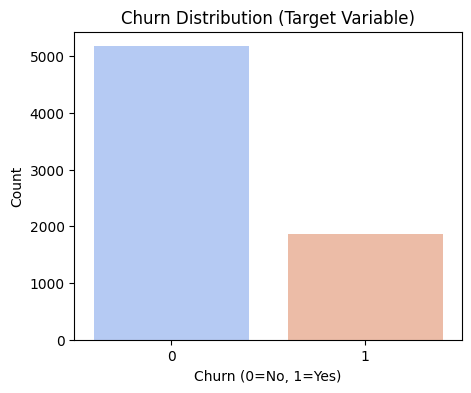

In [18]:
# 8. Visualizations
# -----------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Churn Distribution (Target Variable)")
plt.xlabel("Churn (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()

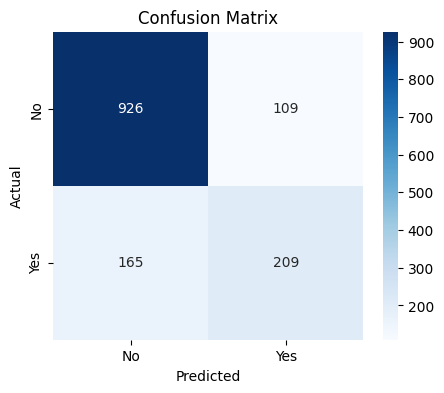

In [19]:
# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

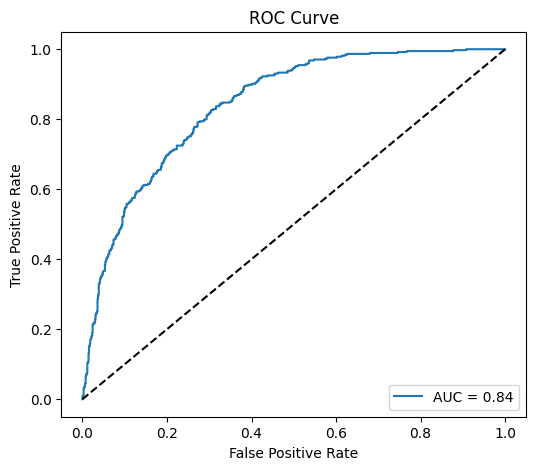

In [20]:
# 3. ROC Curve + AUC
y_pred_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [23]:
# 4. Feature Importance (only for Random Forest)
if isinstance(best_model.best_estimator_.named_steps["classifier"], RandomForestClassifier):
    rf = best_model.best_estimator_.named_steps["classifier"]
    ohe = best_model.best_estimator_.named_steps["preprocessor"].named_transformers_["cat"]

    # Get feature names after encoding
    cat_features = ohe.get_feature_names_out(cat_features)
    all_features = np.concatenate([num_features, cat_features])

    importances = rf.feature_importances_
    indices = np.argsort(importances)[-15:]  # top 15

    plt.figure(figsize=(8,6))
    sns.barplot(x=importances[indices], y=all_features[indices], palette="viridis")
    plt.title("Top 15 Important Features (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
plt.show()

In [24]:
print(best_model.best_estimator_)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                               

C:\Users\Ahsan Computer\AppData\Local\Temp\ipykernel_684\1525776723.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=all_features[indices], palette="viridis")


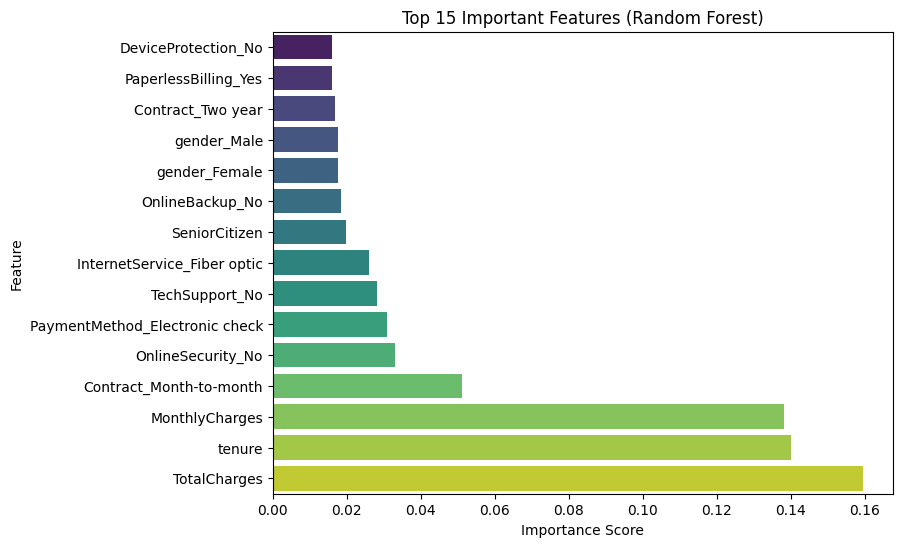

In [25]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_pipeline.fit(X_train, y_train)

rf = rf_pipeline.named_steps["classifier"]
ohe = rf_pipeline.named_steps["preprocessor"].named_transformers_["cat"]

# Get feature names
cat_encoded = ohe.get_feature_names_out(cat_features)
all_features = np.concatenate([num_features, cat_encoded])

importances = rf.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(8,6))
sns.barplot(x=importances[indices], y=all_features[indices], palette="viridis")
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
